# Problem Session 5

The problems in this notebook will cover the content covered in our Inference I lectures including:
- Hypothesis Testing
- Confidence Intervals
- Linear Regression Inference

#### 1. The dangers of early peeking in A/B testing

One especially common use of hypothesis testing in data science is "A/B testing".

Many companies which prioritize data informed decision making have very mature A/B testing platforms to trial changes before adoption.  Here is an example of an A/B test which comes from the book "Trustworthy Online Controlled Experiments" by Kohavi, Tang and Xu:

Someone at your company proposes implementing a coupon code system.  To rapidly get some idea of the potential impacts even *before* implementing the complete system you decide to implement the following A/B test:  for a period of two weeks you will show half of your customers your standard checkout page (the "control group"), and you will show the other half a new checkout page which has a coupon code box (the "treatment group"). Since there are no coupon codes in existence yet, putting anything in the box will simply display "invalid code" and otherwise do nothing.

You will monitor how customers interact with the coupon code box (how many people click on it, enter anything into it, enter one or more attempted codes, etc), how long they stay on the checkout page in the control and treatment group, what fraction of customers who make it to the checkout page who actually complete their purchase, and the revenue per customer who made it to the checkout page.

In this example, the mere presence of a coupon code box significantly reduced revenue per customer with an effect size large enough to scuttle the project!

It is common (but ill advised) for companies to **continuously** monitor such experiments and stop early when a significant result is obtained in either direction.  The reasoning is that we would not want to continue a disastrous experiment for the full planned time (e.g.  hardly anyone checks out after being presented with the coupon code box), and we would likewise not want to miss out on the benefits by **not** implementing a positive experiment as soon as possible.

In this exercise we will see why early stopping is such a bad idea through simulation.

##### a)

Finish the definition of the following function:

In [124]:
import numpy as np

def simulate_data(control_mean, treatment_mean, scale, size):
    '''
    Draws from two normal distributions with the same scale and different means

    Args:
        control_mean:  the mean of the control group
        treatment_mean: the mean of the treatment group
        scale: the common standard deviation of both groups
        size: the shape of both outputs
    
    returns:
        The tuple (control_data, treatment_data)        
    '''
    control_data = np.random.normal(loc = control_mean, scale = scale, size = size)
    treatment_data = np.random.normal(loc = treatment_mean, scale = scale, size = size)
    return (control_data, treatment_data)


# Note: for the probabilistic checks below, the probability of both false positive and negatives are so low as to be effectively zero
# It is a fun little puzzle to estimate these probabilities.
assert(simulate_data(3,3,1,(10,2))[0].shape == (10,2)), "control_data does not have the correct shape"
assert(simulate_data(3,3,1,(10,2))[1].shape == (10,2)), "treatment_data does not have the correct shape"
assert(np.abs(simulate_data(0,3,1,(1000))[0].mean()) < 1  ), "control_data does not have the correct mean"
assert(np.abs(simulate_data(0,3,1,(1000))[1].mean() - 3) < 1  ), "treatment_data does not have the correct mean"
assert(np.abs(simulate_data(0,3,1,(1000))[0].std() - 1) < 0.5 ), "control_data does not have the correct standard deviation"
assert(np.abs(simulate_data(0,3,1,(1000))[1].std() - 1) < 0.5 ), "treatment_data does not have the correct standard deviation"

##### b)

Read the following documentation:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

Use the `ttest_ind` to finish writing the following two functions:

In [125]:
from statsmodels.stats.weightstats import ttest_ind

def no_early_peeking_results(control_data, treatment_data):
    '''
    Returns the p-value of the t-test comparing the two group means.
    '''
    p_value = ttest_ind(control_data, treatment_data)[1]
    return p_value

assert(no_early_peeking_results([1,2,3], [4,5,6]) == 0.021311641128756727)

In [126]:
def early_peeking_results(control_data, treatment_data, alpha):
    '''
    Runs a t-test on each initial segment of the control and treatment data.

    Args:
        alpha: the threshold for significance.
        
    Returns: 
        (p_value, nobs)
        p_value: the p-value of the first significant such test
        nobs: the number of observations in that test
    
    Example:  
        early_peeking_results([1,2,2,2,2,2], [4,5,5,5,5,5], 0.05)
        Should run a t-test on 
            [1,2], [4,5]
            [1,2,2], [4,5,5]
            [1,2,2,2], [4,5,5,5]
            etc
        when a significant p-value is found it will output
        that p-value and the length of the control group for that test.
    '''
    p_value = 1
    nobs = 2
    while p_value > alpha and nobs < len(control_data):
        p_value = ttest_ind(control_data[:nobs], treatment_data[:nobs])[1]
        nobs += 1
    return p_value, nobs

assert(early_peeking_results([1,2,2,2,2,2], [4,5,5,5,5,5], 0.05)[0] == 0.0031255892524457277)
assert(early_peeking_results([1,2,2,2,2,2], [4,5,5,5,5,5], 0.05)[1] == 4)

##### c)

We will now see the impact of early peeking on the false positive rate.

By setting both the control and training mean to 0, and $\alpha = 0.05$ for the threshold for significance, we should expect to see a false positive rate of roughly $0.05$.  We will see that early peeking wildly inflates the false positive rate!

This is bad news for our company, because we will be mislead into thinking that our treatment has a significant effect (in either direction) when there really is no effect at all.

In [127]:
def comparing_procedures(control_mean = 0, 
                            treatment_mean = 0, 
                            scale = 1, 
                            size = 1000, 
                            num_simulations = 100, 
                            alpha = 0.05):
    '''
    Simulates data from both control and treatment groups.
    Returns the following self explanatory variables:
        no_early_peeking_false_positives of type int
        early_peeking_false_positives of type int
        early_peeking_nobs of type list(int)
    '''                
    no_early_peeking_false_positives = 0
    early_peeking_false_positives = 0
    early_peeking_nobs = []

    for i in range(100):
        control_data, treatment_data = simulate_data(control_mean,treatment_mean,scale,size)
        no_early_peeking_p_value = no_early_peeking_results(control_data, treatment_data)
        early_peeking_p_value, nobs = early_peeking_results(control_data, treatment_data, alpha)
        if no_early_peeking_p_value < 0.05:
            no_early_peeking_false_positives += 1
        if early_peeking_p_value < 0.05:
            early_peeking_false_positives += 1
        early_peeking_nobs.append(nobs)

    early_peeking_nobs = np.array(early_peeking_nobs)

    return (no_early_peeking_false_positives, early_peeking_false_positives, early_peeking_nobs)

In [128]:
num_simulations = 100
size = 1000
(no_early_peeking_false_positives, early_peeking_false_positives, early_peeking_nobs) = comparing_procedures(num_simulations=num_simulations, size = size)
print(f"The number of false positives with no early peeking is {no_early_peeking_false_positives} out of {num_simulations}")
print(f"The number of false positives with early peeking is {early_peeking_false_positives} out of {num_simulations}")
print(f"The number of observations to reach those false positives (out of {size}) were \n {early_peeking_nobs[early_peeking_nobs != 1000]}")

The number of false positives with no early peeking is 6 out of 100
The number of false positives with early peeking is 63 out of 100
The number of observations to reach those false positives (out of 1000) were 
 [791 164  74   4  64   4  16  50   4   5  33 335  54  59  13 242  39   3
  18 588 458  56   8   4 169   5  10 136 197 168  16  41  32  11  10  18
 441   4  61  57  21 172 334  58   4  89   8   5  86  49 197  20  10  51
  83  20  12  28 444  11   8   4  72]


#### 2. Confidence Intervals and Linear Regression Coefficients


In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

The following [dataset](https://dasl.datadescription.com/datafile/bodyfat/) comes from the [Data and Story Library](https://dasl.datadescription.com/). 

Our target variable is `Pct.BF` which stands for "percent body fat".

Age is given in years, weight is given in pounds, and all other measurements are given in inches.

In [130]:
bodyfat = pd.read_csv('../../data/bodyfat.csv')
bodyfat.head()

,Pct.BF,Age,Weight,Height,Neck,Chest,Abdomen,Waist,Hip,Thigh,Knee,Ankle,Bicep,Forearm,Wrist
0,12.3,23,154.25,67.75,36.2,93.1,85.2,33.543307,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,173.25,72.25,38.5,93.6,83.0,32.677165,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,154.00,66.25,34.0,95.8,87.9,34.606299,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,184.75,72.25,37.4,101.8,86.4,34.015748,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,184.25,71.25,34.4,97.3,100.0,39.370079,101.9,63.2,42.2,24.0,32.2,27.7,17.7


This table does not include [Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index), but we can calculate it from the data.

Add a new column `BMI` which records this.

In [131]:
bodyfat['BMI'] = (bodyfat.Weight/2.2)/(bodyfat.Height/39.4)**2

The name of the target variable `Pct.BF` is a bit problematic for `statsmodels` because of the period.  Change the name of that column to `BFP`.

In [132]:
bodyfat = bodyfat.rename(columns={'Pct.BF':'BFP'})

Fit the following regression models:

In [138]:
# full_model uses BMI, Waist, and Abdomen as features
full_model = smf.ols('BFP ~ BMI + Waist + Abdomen', data=bodyfat).fit()

# waist_model uses Waist as the only feature
waist_model = smf.ols('BFP ~ Waist', data=bodyfat).fit()

# bmi_model uses BMI as the only feature
bmi_model = smf.ols('BFP ~ BMI', data=bodyfat).fit()

# abdomen_model uses BMI as the only feature
abdomen_model = smf.ols('BFP ~ Abdomen', data=bodyfat).fit()

Look at the summary of each model.  Do they tell a consistent story?

For each model discuss the following with your group:

1. Describe *precisely* what is the meaning of the $p$-value listed for each feature.
2. Describe *precisely* what is the meaning of the $95\%$ confidence interval listed for each feature.
2. How can it be that a feature is considered significant by one model and not by another?
3. Can you explain any unusual findings? 

In [134]:
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BFP   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     174.4
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           1.30e-60
Time:                        13:08:37   Log-Likelihood:                -740.61
No. Observations:                 250   AIC:                             1489.
Df Residuals:                     246   BIC:                             1503.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -42.7717      2.780    -15.386      0.000     -48.247     -37.296
BMI           -0.1016      0.220     -0.462      0.645      -0.535       0.332
Waist       1.085e+06   1.06e+06      1.023      0.307      -1e+06    3.17e+06
Abdomen    -4.273e+05   4.18e+05     -1.023      0.307   -1.25e+06    3.95e+05
==============================================================================
Omnibus:                        4.380   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                2.973
Skew:                           0.087   Prob(JB):                        0.226
Kurtosis:                       2.495   Cond. No.                     3.93e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.71e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [135]:
waist_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BFP   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     523.3
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           4.85e-63
Time:                        13:08:37   Log-Likelihood:                -741.29
No. Observations:                 250   AIC:                             1487.
Df Residuals:                     248   BIC:                             1494.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -42.7341      2.717    -15.731      0.000     -48.084     -37.384
Waist          1.7000      0.074     22.875      0.000       1.554       1.846
==============================================================================
Omnibus:                        4.921   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                3.148
Skew:                           0.071   Prob(JB):                        0.207
Kurtosis:                       2.469   Cond. No.                         333.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
bmi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BFP   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     309.0
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           1.82e-45
Time:                        13:08:37   Log-Likelihood:                -781.98
No. Observations:                 250   AIC:                             1568.
Df Residuals:                     248   BIC:                             1575.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -27.6458      2.679    -10.321      0.000     -32.922     -22.370
BMI            1.8389      0.105     17.577      0.000       1.633       2.045
==============================================================================
Omnibus:                        5.098   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                3.109
Skew:                          -0.019   Prob(JB):                        0.211
Kurtosis:                       2.455   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [139]:
abdomen_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BFP   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     523.3
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           4.85e-63
Time:                        13:14:12   Log-Likelihood:                -741.29
No. Observations:                 250   AIC:                             1487.
Df Residuals:                     248   BIC:                             1494.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -42.7341      2.717    -15.731      0.000     -48.084     -37.384
Abdomen        0.6693      0.029     22.875      0.000       0.612       0.727
==============================================================================
Omnibus:                        4.921   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                3.148
Skew:                           0.071   Prob(JB):                        0.207
Kurtosis:                       2.469   Cond. No.                         846.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Use an F-test to compare the full model to the waist, abdomen, and bmi models.  What is the precise meaning of the $p$-value of each test? 

In [142]:
# Perform the F-test
f_test_waist = full_model.compare_f_test(waist_model)
f_test_bmi = full_model.compare_f_test(bmi_model)
f_test_abdomen = full_model.compare_f_test(abdomen_model)


print("p-value of full compared to waist model:", f_test_waist[1])
print("p-value of full compared to abdomen model:", f_test_abdomen[1])
print("p-value of full compared to BMI model:", f_test_bmi[1])


p-value of full compared to waist model: 0.5114113073117954
p-value of full compared to abdomen model: 0.5114104372346672
p-value of full compared to BMI model: 2.079035772690264e-18


If you have not already, make a plot of `waist` against `abdomen` to help explain what we have been seeing:

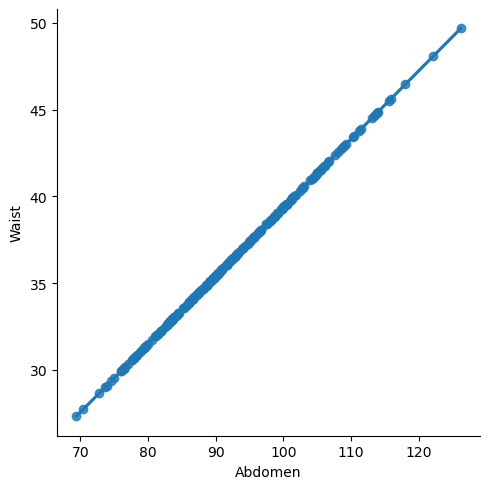

In [144]:
sns.lmplot(data=bodyfat, x= 'Abdomen', y = 'Waist')
plt.show()

Let's choose the waist model as our final model.  Make a graph which includes:

1. A scatterplot of the data
2. The confidence interval for the predicted mean response.
3. The prediction interval for the response.

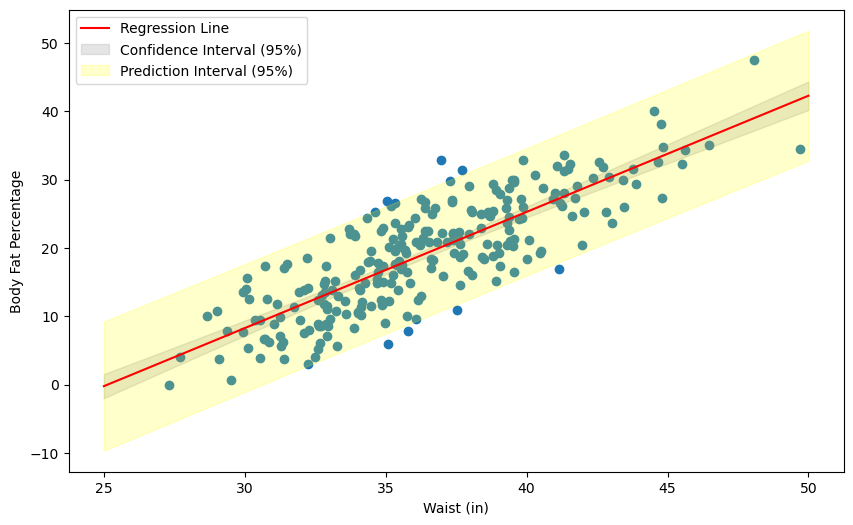

In [145]:
xs = np.linspace(25, 50)

# Create a DataFrame with the same structure as the one used for training
df_xs = pd.DataFrame({'Waist': xs})

# Get predictions using the new DataFrame
predictions = waist_model.get_prediction(df_xs)

pred_summary_frame = predictions.summary_frame(alpha=0.05)

# Extract values
mean_pred = pred_summary_frame['mean']
mean_ci_lower = pred_summary_frame['mean_ci_lower']
mean_ci_upper = pred_summary_frame['mean_ci_upper']
obs_ci_lower = pred_summary_frame['obs_ci_lower']
obs_ci_upper = pred_summary_frame['obs_ci_upper']

# Plotting
plt.figure(figsize=(10, 6))

plt.scatter(bodyfat.Waist, bodyfat.BFP)

plt.plot(xs, mean_pred, 'r-', label='Regression Line')
plt.fill_between(xs, mean_ci_lower, mean_ci_upper, color='gray', alpha=0.2, label='Confidence Interval (95%)')
plt.fill_between(xs, obs_ci_lower, obs_ci_upper, color='yellow', alpha=0.2, label='Prediction Interval (95%)')
plt.xlabel('Waist (in)')
plt.ylabel('Body Fat Percentage')
plt.legend()
plt.show()

Discuss the precise meanings of these confidence and prediction intervals.